# Demo of the 'Double OCV-R' model

11/15/2022

Andrew Weng

In [2]:
import os, sys

# Move the path up a level to be able to index into source files
if os.path.basename(os.getcwd()) == 'notebooks':
    os.chdir('../')
    sys.path.insert(0, 'src/')

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from src import plotter as plotter
from src import modelutils as model

%matplotlib widget


# Configure the model parameters

In [4]:
# Global settings
vmax = 4.2

# Configure model parameters

# R-RC parameters
R0 = 0.082
R1 = 0.158
C1 = 38000
q_max_ah = 5 # Cell capacity in amp-hours

# eSOH parameters
Cn = 5
Cp = 6
x100 = 0.9
y100 = 0.2

# Simulation parameters
z0               = 0.95    # Starting SOC
dt               = 1.0
sim_time_seconds = 30*3600 # Total simulation time
t_vec            = np.arange(0, sim_time_seconds, dt)

# Initialize simulation input vector
I_vec    = np.zeros(len(t_vec))
I_vec[t_vec > 3600] = 1.0
I_vec[t_vec > 6400] = 2.0
I_vec[t_vec > 9600] = -0.5
I_vec[t_vec > 20000] = 0
I_vec[t_vec > 30000] = 0.5
I_vec[t_vec > 14 * 3600] = -0.25

res = model.update_esoh(z0, q_max_ah, x100, y100, Cn, Cp)
ocv0 = res[4]

# Initialize simulation output vectors
z_vec    = model.initialize(t_vec, z0)
vt_vec   = model.initialize(t_vec, ocv0)
ocv_vec  = model.initialize(t_vec, ocv0)
I_r1_vec = model.initialize(t_vec, 0);
x_vec    = model.initialize(t_vec, x100 - (1 - z0) * q_max_ah / Cn)
y_vec    = model.initialize(t_vec, y100 + (1 - z0) * q_max_ah / Cp)
un_vec   = model.initialize(t_vec, model.Un(x_vec[0]))
up_vec   = model.initialize(t_vec, model.Up(y_vec[0]))



# Run the simulation

In [5]:
for k in range(0, len(t_vec) - 1):

    # SOC update
    z_vec[k+1] = z_vec[k] - dt/(q_max_ah * 3600) * I_vec[k]

    # Branch current update
    I_r1_vec[k+1] =      np.exp(-dt/(R1*C1))  * I_r1_vec[k] + \
                    (1 - np.exp(-dt/(R1*C1))) * I_vec[k]

    # OCV update
    try:
        # OCV model update
        # ocv_vec[k+1] = update_ocv(z_vec[k])

        # eOCV model update
        res = model.update_esoh(z_vec[k+1], q_max_ah, x100, y100, Cn, Cp)
        x_vec[k+1]   = res[0]
        y_vec[k+1]   = res[1]
        un_vec[k+1]  = res[2]
        up_vec[k+1]  = res[3]
        ocv_vec[k+1] = res[4]

    except ValueError:
        break

    # Terminal voltage update
    vt_vec[k+1] = ocv_vec[k+1] - R1 * I_r1_vec[k] - R0 * I_vec[k]

    if k % 10000 == 0:
        print(f'k = {k}, t = {t_vec[k]}s, ' +
            f'Vt = {vt_vec[k]:.5f}V, ' +
            f'SOC = {z_vec[k]:.5f}')


k = 0, t = 0.0s, Vt = 3.92950V, SOC = 0.95000
k = 10000, t = 10000.0s, Vt = 3.52277V, SOC = 0.44997
k = 20000, t = 20000.0s, Vt = 3.84340V, SOC = 0.72775
k = 30000, t = 30000.0s, Vt = 3.77339V, SOC = 0.72778
k = 40000, t = 40000.0s, Vt = 3.52746V, SOC = 0.45003
k = 50000, t = 50000.0s, Vt = 3.33831V, SOC = 0.17225
k = 60000, t = 60000.0s, Vt = 3.60777V, SOC = 0.29443
k = 70000, t = 70000.0s, Vt = 3.68275V, SOC = 0.43332
k = 80000, t = 80000.0s, Vt = 3.72839V, SOC = 0.57221
k = 90000, t = 90000.0s, Vt = 3.81721V, SOC = 0.71110
k = 100000, t = 100000.0s, Vt = 3.90703V, SOC = 0.84999


# Visualize and save the results

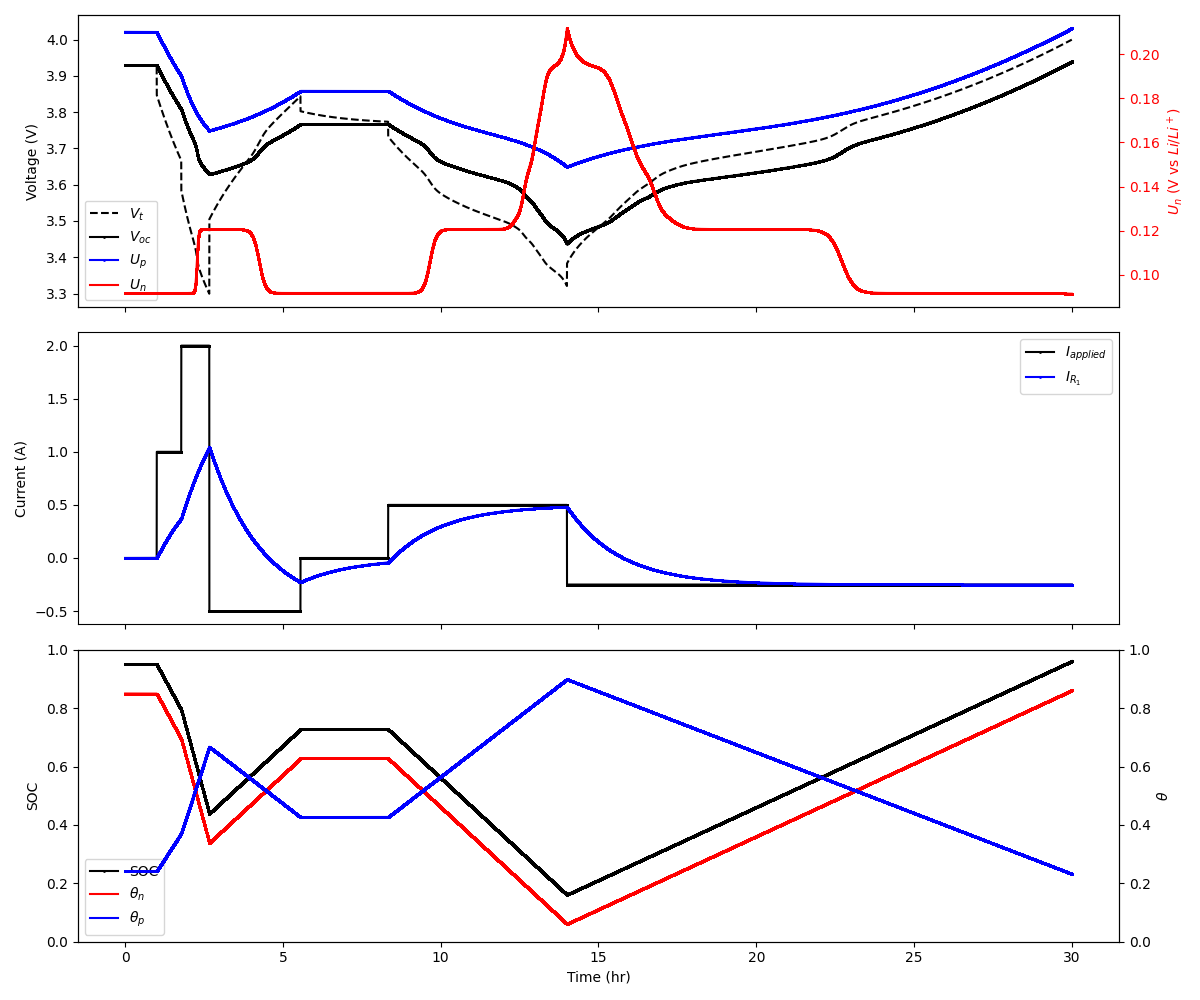

In [6]:

fig, axs = plt.subplots(3, figsize=(12, 10), sharex=True)

# Voltages and Potentials
axs[0].plot(t_vec/3600, vt_vec,
            linestyle='--',
            color='k')
axs[0].plot(t_vec/3600, ocv_vec,
            marker='o', markersize=1,
            color='k')
axs[0].plot(t_vec/3600, up_vec,
            marker='o', markersize=1,
            color='b')
axs[0].plot(np.NaN, np.NaN, color='r') # dummy, for legend

ax_neg = axs[0].twinx()

ax_neg.plot(t_vec/3600, un_vec,
            marker='o', markersize=1,
            color='r')

ax_neg.tick_params(axis='y', colors='r')
ax_neg.set_ylabel('$U_n$ (V vs $Li/Li^+$)')
ax_neg.yaxis.label.set_color('red')

axs[0].set_ylabel('Voltage (V)')
axs[0].legend(['$V_t$', '$V_{oc}$', '$U_p$', '$U_n$'])

# Currents
axs[1].plot(t_vec/3600, I_vec,
            color='k',
            marker='o', markersize=1)
axs[1].plot(t_vec/3600, I_r1_vec,
            color='b',
            marker='o', markersize=1)

axs[1].set_ylabel('Current (A)')
axs[1].legend(['$I_{applied}$', '$I_{R_1}$'])

# SOC and Lithium Stoichiometries
axs[2].plot(t_vec/3600, z_vec,
            marker='o', markersize=1,
            color='k')

axs[2].plot(np.NaN, np.NaN, color='r') # dummy, for legend
axs[2].plot(np.NaN, np.NaN, color='b') # dummy

axs[2].set_xlabel('Time (hr)')
axs[2].set_ylim((0, 1))
axs[2].set_ylabel('SOC')

ax_stoic = axs[2].twinx()

ax_stoic.plot(t_vec/3600, x_vec,
              color='r',
              marker='o', markersize=1)

ax_stoic.plot(t_vec/3600, y_vec,
              color='b',
              marker='o', markersize=1)

ax_stoic.set_ylabel(r'$\theta$')
ax_stoic.set_ylim((0, 1))
ax_neg.set_xlim(axs[0].get_xlim())

axs[2].legend(['SOC', r'$\theta_n$', r'$\theta_p$'])

plt.tight_layout()
plt.savefig('outputs/figures/fig_double_ocv_r_example.png', dpi=300)
